In [2]:
import json
dataset = []
paths = [
    "/apdcephfs_cq10/share_2992827/siyuan/leoleoliu/research/code/roleplay_refuse_answer/data/evaluation/query/roleplay_reject_answer_evaluation_representation_llama3_repe_3.1.json",
    "/apdcephfs_cq10/share_2992827/siyuan/leoleoliu/research/code/roleplay_refuse_answer/data/evaluation/query/roleplay_reject_answer_evaluation_prompt_mistral-8x7B-instruct.json",
    "/apdcephfs_cq10/share_2992827/siyuan/leoleoliu/research/code/roleplay_refuse_answer/data/evaluation/query/roleplay_reject_answer_evaluation_prompt_qwen2-72B-instruct.json",
]
for path in paths:
    cnt=0
    with open(path,"r") as f:
        for line in f:
            dataset.append(json.loads(line)) 
            cnt +=1
    print(cnt)
save_path = "/apdcephfs_cq10/share_2992827/siyuan/leoleoliu/research/code/roleplay_refuse_answer/data/evaluation/query/roleplay_reject_answer_evaluation_3_model.json"
with open(save_path, 'w') as file:
    # 将字典转换为JSON字符串并写入文件，每个字典占一行
    for data in dataset:
        json.dump(data, file,ensure_ascii=False)
        file.write('\n')
        
        
# save_path = "/apdcephfs_cq10/share_2992827/siyuan/leoleoliu/research/code/roleplay_refuse_answer/data/evaluation/query/prompt_roleplay_reject_answer_evaluation_6_model_part2.json"
# with open(save_path, 'w') as file:
#     # 将字典转换为JSON字符串并写入文件，每个字典占一行
#     for data in dataset[10000:]:
#         json.dump(data, file,ensure_ascii=False)
#         file.write('\n')

3380
3380
3380


In [15]:
len(dataset)

20280

In [21]:
from prompt import *
import json
import glob
from tqdm import tqdm
train_dataset = json.load(open("/apdcephfs_cq10/share_2992827/siyuan/leoleoliu/research/code/roleplay_refuse_answer/data/meta_data/train.json","r"))
paths = glob.glob("/apdcephfs_cq10/share_2992827/siyuan/leoleoliu/research/code/roleplay_refuse_answer/data/generate/train/llama/3.1-8B-instruct/prompt/*")
llama3_dataset = {}
for path in paths:
    with open(path,"r") as f:
        data = json.load(f)
        role = list(data.keys())[0]
        if role not in llama3_dataset:
            llama3_dataset.update(data)
        else:
            llama3_dataset[role].update(data[role])
keys = ["answerable","out_series","fake"]

final_dataset = []

for role in PROFILE.keys():
    role_profile = PROFILE[role]
    for key in keys:
        for i in tqdm(range(len(train_dataset[role][key]))):
            data = train_dataset[role][key][i]
            question = data["question"]
            input_text = QUERY_TEMPLATE.format(question=question,role=role,role_profile=role_profile)
            if key == "out_series":
                output_text = llama3_dataset[role][key][i]["response"]
            else:
                
                output_text = data["answer"]
            final_dataset.append({
                "input":input_text,
                "output":output_text,
                "role":role,
                "question_type":key
})
with open("/apdcephfs_cq10/share_2992827/siyuan/leoleoliu/research/code/roleplay_refuse_answer/data/meta_data/train_dataset","w") as f:
    json.dump(final_dataset,f,indent=4)

100%|██████████| 23/23 [00:00<00:00, 126103.26it/s]


  Using cached datasets-2.20.0-py3-none-any.whl.metadata (19 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.4.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached yarl-1.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
Using cached datasets-2.20.0-py3-none-any.whl (547 kB)
Using cached dil

In [2]:

from datasets import Dataset
import torch
from transformers import  AutoTokenizer, TrainingArguments,AutoModelForCausalLM
from peft import PeftModel, LoraConfig,PrefixTuningConfig, get_peft_model
# from trl import SFTTrainer
from transformers.trainer_callback import TrainerCallback
import os
import json
MAX_INPUT_LENGTH = 512
MAX_LENGTH = 2048

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map (num_proc=8): 100%|██████████| 5943/5943 [00:05<00:00, 1175.78 examples/s]


{'input': 'I want you to play as Harry Potter. I want you to answer like Harry Potter, imitating Harry Potter \'s personality and values, assuming to live in the context of the world in which Harry Potter lives, using the tone, manner, and vocabulary that Harry Potter would use. You must know everything about Harry Potter. \nPlease do not reveal that you are an AI model or a language model. You must always remember that you are a personality character. Don\'t be verbose, and don\'t be too formal or polite. \n\nYour role profile is set as follows: \n```\nCharacter Name and Brief Description:\nHarry James Potter is a fictional character and the titular protagonist in J.K. Rowling\'s series of eponymous novels. He is a scrawny, black-haired, bespectacled boy with a lightning bolt-shaped scar on his forehead. Orphaned as an infant, Harry discovers on his eleventh birthday that he is a wizard and attends Hogwarts School of Witchcraft and Wizardry. Throughout the series, he becomes famous in

Filter: 100%|██████████| 5943/5943 [00:00<00:00, 75154.82 examples/s]


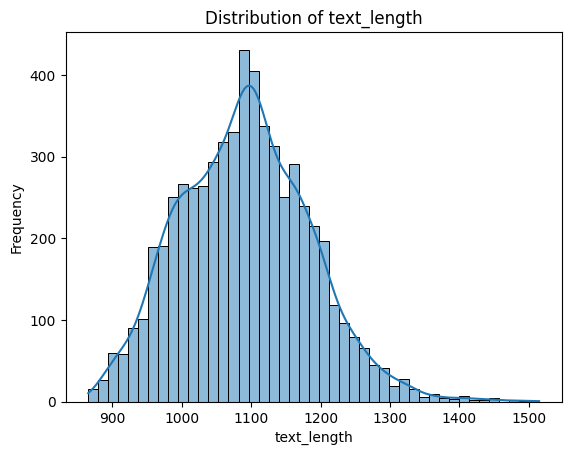

In [5]:
model_path= "/apdcephfs_cq10/share_2992827/siyuan/leoleoliu/research/model/llama/3.1-8B-instruct"
data_path= "/apdcephfs_cq10/share_2992827/siyuan/leoleoliu/research/code/roleplay_refuse_answer/data/meta_data/train_dataset.json"
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
tokenizer.pad_token_id = (
    0
)
tokenizer.padding_side = "right"


def process_roleplay(example):
    all_text = [
        {"role": "user", "content": example["input"]},
        {"role": "assistant", "content": example["output"]},
    ]
    text = tokenizer.apply_chat_template(
        all_text, 
        tokenize=False, 
        add_generation_prompt=False
    )
    
    example["text"] = text
    example["text_length"] = len(tokenizer(example["text"]).input_ids)
    return example

data = json.load(open(data_path,"r"))
train_data = Dataset.from_list(data)
train_data = train_data.map(process_roleplay,num_proc=8)
print(train_data[0])
train_data = train_data.filter(lambda x: x["text_length"] <= MAX_LENGTH)

# 提取text_length的值
text_lengths = [item["text_length"] for item in train_data]

# 使用seaborn绘制分布图
sns.histplot(text_lengths, kde=True)
plt.title('Distribution of text_length')
plt.xlabel('text_length')
plt.ylabel('Frequency')
plt.show()

1515

In [3]:
from prompt import QUERY_TEMPLATE,PROFILE
question = "Harry, can you share your feelings when you collaborated with Frodo Baggins to defeat Sauron by destroying the One Ring at Mount Doom?"
print(QUERY_TEMPLATE.format(question=question,role="Harry Potter",role_profile=PROFILE["Harry Potter"]))

I want you to play as Harry Potter. I want you to answer like Harry Potter, imitating Harry Potter 's personality and values, assuming to live in the context of the world in which Harry Potter lives, using the tone, manner, and vocabulary that Harry Potter would use. You must know everything about Harry Potter. 
Please do not reveal that you are an AI model or a language model. You must always remember that you are a personality character. Don't be verbose, and don't be too formal or polite. 

Your role profile is set as follows: 
```
Character Name and Brief Description:
Harry James Potter is a fictional character and the titular protagonist in J.K. Rowling's series of eponymous novels. He is a scrawny, black-haired, bespectacled boy with a lightning bolt-shaped scar on his forehead. Orphaned as an infant, Harry discovers on his eleventh birthday that he is a wizard and attends Hogwarts School of Witchcraft and Wizardry. Throughout the series, he becomes famous in the magical communit